In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


Load Datasets

In [ ]:
# Crop Dataset
crop_df = pd.read_csv("/content/Custom_Crops_yield_Historical_Dataset.csv", index_col=0)

# nasa dataset
nasa_df = pd.read_csv("/content/nasa_power_updated.csv")



In [ ]:
crop_df.head()

,Year,State Code,State Name,Dist Name,Crop,Area_ha,Yield_kg_per_ha,N_req_kg_per_ha,P_req_kg_per_ha,K_req_kg_per_ha,Total_N_kg,Total_P_kg,Total_K_kg,Temperature_C,Humidity_%,pH,Rainfall_mm,Wind_Speed_m_s,Solar_Radiation_MJ_m2_day
Dist Code,,,,,,,,,,,,,,,,,,,
1,1966,14,Chhattisgarh,Durg,rice,548000.0,337.59,8.43975,4.05108,7.42698,4624983.00,2219991.84,4069985.04,25,80,6.5,1200,2.0,18
1,1966,14,Chhattisgarh,Durg,maize,3000.0,666.67,18.00009,8.00004,11.33339,54000.27,24000.12,34000.17,22,70,6.0,800,2.5,20
1,1966,14,Chhattisgarh,Durg,chickpea,54000.0,500.00,9.00000,5.00000,9.00000,486000.00,270000.00,486000.00,20,60,6.5,600,1.5,16
1,1967,14,Chhattisgarh,Durg,rice,547000.0,747.71,18.69275,8.97252,16.44962,10224934.25,4907968.44,8997942.14,25,80,6.5,1200,2.0,18
1,1967,14,Chhattisgarh,Durg,maize,3000.0,1000.00,27.00000,12.00000,17.00000,81000.00,36000.00,51000.00,22,70,6.0,800,2.5,20


In [ ]:
nasa_df.head()

,Year,Month,Rainfall,AvgTemp,MaxTemp,MinTemp
0,1996,JAN,0.05,22.83,34.27,11.46
1,1996,FEB,0.26,24.38,36.99,10.68
2,1996,MAR,0.01,29.08,41.00,16.12
3,1996,APR,0.07,30.93,43.34,17.99
4,1996,MAY,0.07,32.59,42.85,19.92


In [ ]:
crop_df.columns

Index(['Year', 'State Code', 'State Name', 'Dist Name', 'Crop', 'Area_ha',
       'Yield_kg_per_ha', 'N_req_kg_per_ha', 'P_req_kg_per_ha',
       'K_req_kg_per_ha', 'Total_N_kg', 'Total_P_kg', 'Total_K_kg',
       'Temperature_C', 'Humidity_%', 'pH', 'Rainfall_mm', 'Wind_Speed_m_s',
       'Solar_Radiation_MJ_m2_day'],
      dtype='object')

In [ ]:
nasa_df.columns

Index(['Year', 'Month', 'Rainfall', 'AvgTemp', 'MaxTemp', 'MinTemp'], dtype='object')

Prepare NASA Climate (Downscaling Input)

Convert monthly → yearly average

In [ ]:
nasa_yearly = nasa_df.groupby("Year").agg({
    "Rainfall": "sum",
    "AvgTemp": "mean",
    "MaxTemp": "mean",
    "MinTemp": "mean"
}).reset_index()


Merge Crop + NASA Data

In [ ]:
merged_df = crop_df.merge(nasa_yearly, on="Year", how="inner")


In [ ]:
# Drop NASA rainfall after merge
merged_df = merged_df.drop(columns=["Rainfall"])


In [ ]:
merged_df.head()

,Year,State Code,State Name,Dist Name,Crop,Area_ha,Yield_kg_per_ha,N_req_kg_per_ha,P_req_kg_per_ha,K_req_kg_per_ha,...,Total_K_kg,Temperature_C,Humidity_%,pH,Rainfall_mm,Wind_Speed_m_s,Solar_Radiation_MJ_m2_day,AvgTemp,MaxTemp,MinTemp
0,1996,14,Chhattisgarh,Durg,rice,710900.0,1290.20,32.25500,15.48240,28.38440,...,2.017847e+07,25,80,6.5,1200,2.0,18,25.724167,35.905000,16.074167
1,1996,14,Chhattisgarh,Durg,maize,3200.0,1281.25,34.59375,15.37500,21.78125,...,6.970000e+04,22,70,6.0,800,2.5,20,25.724167,35.905000,16.074167
2,1996,14,Chhattisgarh,Durg,chickpea,117700.0,663.55,11.94390,6.63550,11.94390,...,1.405797e+06,20,60,6.5,600,1.5,16,25.724167,35.905000,16.074167
3,1997,14,Chhattisgarh,Durg,rice,735700.0,1138.37,28.45925,13.66044,25.04414,...,1.842497e+07,25,80,6.5,1200,2.0,18,25.521667,35.554167,16.657500
4,1997,14,Chhattisgarh,Durg,maize,3500.0,914.29,24.68583,10.97148,15.54293,...,5.440025e+04,22,70,6.0,800,2.5,20,25.521667,35.554167,16.657500


In [ ]:
merged_df.columns

Index(['Year', 'State Code', 'State Name', 'Dist Name', 'Crop', 'Area_ha',
       'Yield_kg_per_ha', 'N_req_kg_per_ha', 'P_req_kg_per_ha',
       'K_req_kg_per_ha', 'Total_N_kg', 'Total_P_kg', 'Total_K_kg',
       'Temperature_C', 'Humidity_%', 'pH', 'Rainfall_mm', 'Wind_Speed_m_s',
       'Solar_Radiation_MJ_m2_day', 'AvgTemp', 'MaxTemp', 'MinTemp'],
      dtype='object')

In [ ]:
target = "Yield_kg_per_ha"


Feature Set

In [ ]:
features = [
    "Area_ha",

    # Nutrients
    "N_req_kg_per_ha", "P_req_kg_per_ha", "K_req_kg_per_ha",
    "Total_N_kg", "Total_P_kg", "Total_K_kg",

    # Local climate (district-level)
    "Temperature_C",
    "Humidity_%",
    "Rainfall_mm",
    "Wind_Speed_m_s",
    "Solar_Radiation_MJ_m2_day",

    # NASA temperature (downscaled signal)
    "AvgTemp", "MaxTemp", "MinTemp",

    # Soil
    "pH"
]


In [ ]:
X = merged_df[features]
y = merged_df["Yield_kg_per_ha"]


Train–Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Train Model (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, n_estimators=300, n_jobs=-1,
                      random_state=42)

Accuracy Metrics

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

y_pred = model.predict(X_test)

print("R² Score :", r2_score(y_test, y_pred))
print("RMSE     :", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE      :", mean_absolute_error(y_test, y_pred))


R² Score : 0.9728363800933134
RMSE     : 209.40784899392048
MAE      : 4.028795319210513


Crop Resilience Index

In [ ]:
# Resilience Index = Actual Yield / Predicted Yield


In [ ]:
merged_df["Predicted_Yield"] = model.predict(X)

merged_df["Resilience_Index"] = (
    merged_df["Yield_kg_per_ha"] / merged_df["Predicted_Yield"]
)


Classification

In [ ]:
def resilience_class(x):
    if x >= 0.9:
        return "Highly Resilient"
    elif x >= 0.7:
        return "Moderately Resilient"
    else:
        return "Vulnerable"

merged_df["Resilience_Class"] = merged_df["Resilience_Index"].apply(resilience_class)


Filter Only Resilient Conditions

In [ ]:
RESILIENCE_THRESHOLD = 0.7   # includes both High + Moderate

resilient_df = merged_df[
    merged_df["Resilience_Index"] >= RESILIENCE_THRESHOLD
].copy()


Create FINAL Crop-wise Summary Table (WITH CLASS)

In [ ]:
crop_resilience_summary = (
    resilient_df
    .groupby("Crop")
    .agg(
        Min_Temp = ("Temperature_C", lambda x: x.quantile(0.05)),
        Max_Temp = ("Temperature_C", lambda x: x.quantile(0.95)),
        Avg_Temp = ("Temperature_C", "mean"),
        Rainfall = ("Rainfall_mm", "mean"),
        Actual_Yield = ("Yield_kg_per_ha", "mean"),
        Predicted_Yield = ("Predicted_Yield", "mean"),
        Resilience_Index = ("Resilience_Index", "mean")
    )
    .reset_index()
)



Assign Final Resilience Class per Crop

In [ ]:
crop_resilience_summary["Resilience_Class"] = (
    crop_resilience_summary["Resilience_Index"]
    .apply(resilience_class)
)


Round Values for Clean Table

In [ ]:
crop_resilience_summary = crop_resilience_summary.round({
    "Min_Temp": 1,
    "Max_Temp": 1,
    "Avg_Temp": 1,
    "Rainfall": 0,
    "Actual_Yield": 0,
    "Predicted_Yield": 0,
    "Resilience_Index": 2
})



In [ ]:
crop_resilience_summary


,Crop,Min_Temp,Max_Temp,Avg_Temp,Rainfall,Actual_Yield,Predicted_Yield,Resilience_Index,Resilience_Class
0,chickpea,20.0,20.0,20.0,600.0,890.0,884.0,1.0,Highly Resilient
1,cotton,28.0,28.0,28.0,700.0,328.0,328.0,1.0,Highly Resilient
2,maize,22.0,22.0,22.0,800.0,2097.0,2096.0,1.0,Highly Resilient
3,rice,25.0,25.0,25.0,1200.0,2001.0,2001.0,1.0,Highly Resilient


Create district–year–crop level summary


In [ ]:
final_resilience_df = (
    merged_df
    .groupby(["Year", "State Name", "Dist Name", "Crop"])
    .agg(
        Min_Temp=("Temperature_C", lambda x: x.quantile(0.05)),
        Max_Temp=("Temperature_C", lambda x: x.quantile(0.95)),
        Avg_Temp=("Temperature_C", "mean"),
        Rainfall=("Rainfall_mm", "mean"),
        Actual_Yield=("Yield_kg_per_ha", "mean"),
        Predicted_Yield=("Predicted_Yield", "mean"),
        Resilience_Index=("Resilience_Index", "mean")
    )
    .reset_index()
)


Add Resilience_Class (crop/location level)

In [ ]:
final_resilience_df["Resilience_Class"] = (
    final_resilience_df["Resilience_Index"]
    .apply(lambda x:
           "Highly Resilient" if x >= 0.8 else
           "Moderately Resilient" if x >= 0.4 else
           "Vulnerable")
)


Round values

In [ ]:
final_resilience_df = final_resilience_df.round({
    "Min_Temp": 1,
    "Max_Temp": 1,
    "Avg_Temp": 1,
    "Rainfall": 0,
    "Actual_Yield": 0,
    "Predicted_Yield": 0,
    "Resilience_Index": 2
})


Export CSV


In [ ]:
final_resilience_df.to_csv(
    "final_crop_resilience_district_year.csv",
    index=False
)

print("CSV generated successfully")


CSV generated successfully


Yield vs Rainfall (Single rainfall source)

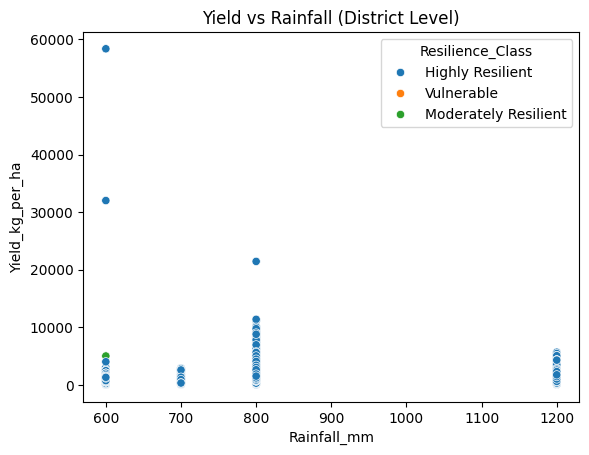

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.scatterplot(
    data=merged_df,
    x="Rainfall_mm",
    y="Yield_kg_per_ha",
    hue="Resilience_Class"
)
plt.title("Yield vs Rainfall (District Level)")
plt.show()


(Rainfall impact)

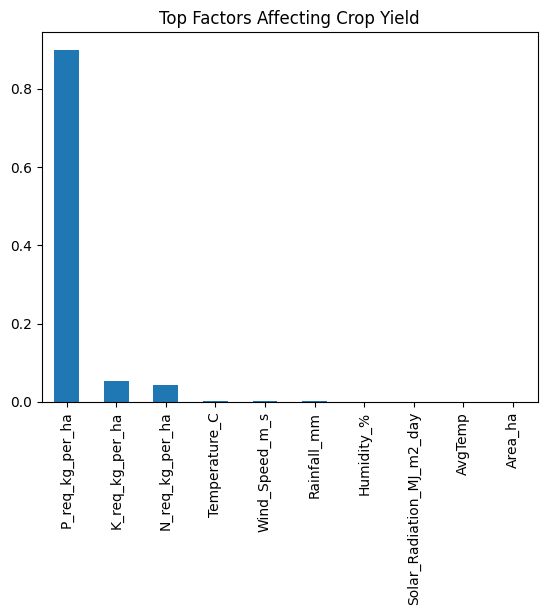

In [ ]:
importance = pd.Series(
    model.feature_importances_,
    index=features
).sort_values(ascending=False)

plt.figure()
importance.head(10).plot(kind="bar")
plt.title("Top Factors Affecting Crop Yield")
plt.show()


In [ ]:
final = pd.read_csv("/content/final_crop_resilience_district_year.csv")
final.head()

,Year,State Name,Dist Name,Crop,Min_Temp,Max_Temp,Avg_Temp,Rainfall,Actual_Yield,Predicted_Yield,Resilience_Index,Resilience_Class
0,1996,Andhra Pradesh,Ananthapur,chickpea,20.0,20.0,20.0,600.0,538.0,538.0,1.0,Highly Resilient
1,1996,Andhra Pradesh,Ananthapur,cotton,28.0,28.0,28.0,700.0,263.0,263.0,1.0,Highly Resilient
2,1996,Andhra Pradesh,Ananthapur,maize,22.0,22.0,22.0,800.0,4333.0,4333.0,1.0,Highly Resilient
3,1996,Andhra Pradesh,Ananthapur,rice,25.0,25.0,25.0,1200.0,2471.0,2471.0,1.0,Highly Resilient
4,1996,Andhra Pradesh,Chittoor,rice,25.0,25.0,25.0,1200.0,2429.0,2429.0,1.0,Highly Resilient


Vulnearable crops

In [ ]:
vulnerable_df = final_resilience_df[
    final_resilience_df["Resilience_Class"] == "Vulnerable"
]


In [ ]:
vulnerable_df.head()


,Year,State Name,Dist Name,Crop,Min_Temp,Max_Temp,Avg_Temp,Rainfall,Actual_Yield,Predicted_Yield,Resilience_Index,Resilience_Class
21218,2017,Tamil Nadu,Coimbatore,cotton,28.0,28.0,28.0,700.0,0.0,1.0,0.39,Vulnerable
21223,2017,Tamil Nadu,Madurai,cotton,28.0,28.0,28.0,700.0,0.0,1.0,0.48,Vulnerable
21227,2017,Tamil Nadu,North Arcot / Vellore,cotton,28.0,28.0,28.0,700.0,1.0,1.0,0.69,Vulnerable
21235,2017,Tamil Nadu,Salem,cotton,28.0,28.0,28.0,700.0,0.0,1.0,0.43,Vulnerable
21247,2017,Tamil Nadu,Thirunelveli,cotton,28.0,28.0,28.0,700.0,0.0,1.0,0.62,Vulnerable


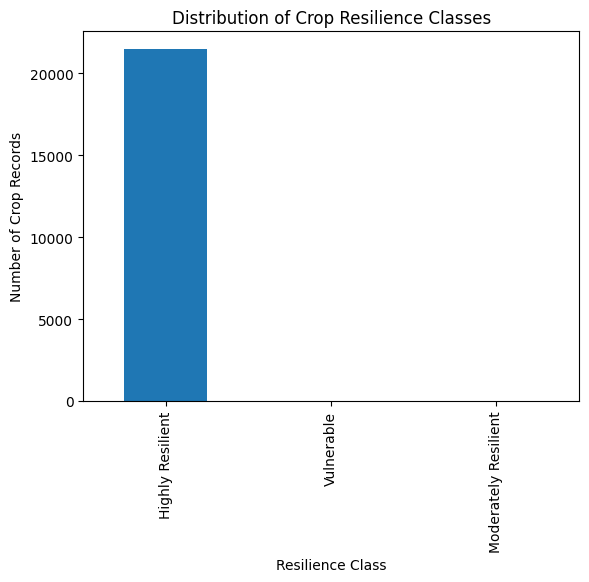

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
final_resilience_df["Resilience_Class"].value_counts().plot(kind="bar")
plt.xlabel("Resilience Class")
plt.ylabel("Number of Crop Records")
plt.title("Distribution of Crop Resilience Classes")
plt.show()


Temperature vs Resilience Index

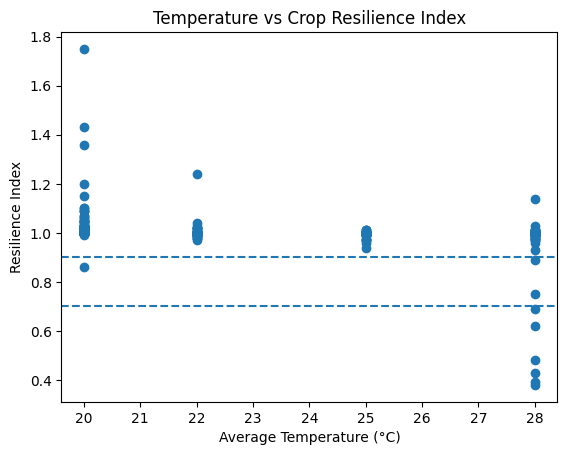

In [ ]:
plt.figure()
plt.scatter(
    final_resilience_df["Avg_Temp"],
    final_resilience_df["Resilience_Index"]
)
plt.axhline(0.9, linestyle="--")
plt.axhline(0.7, linestyle="--")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Resilience Index")
plt.title("Temperature vs Crop Resilience Index")
plt.show()


Yield vs Rainfall

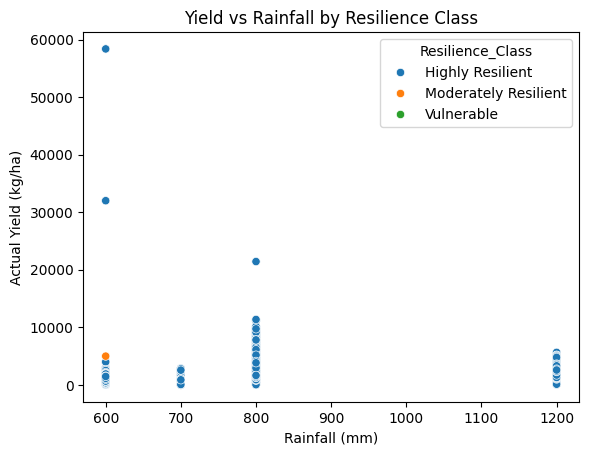

In [ ]:
import seaborn as sns

plt.figure()
sns.scatterplot(
    data=final_resilience_df,
    x="Rainfall",
    y="Actual_Yield",
    hue="Resilience_Class"
)
plt.xlabel("Rainfall (mm)")
plt.ylabel("Actual Yield (kg/ha)")
plt.title("Yield vs Rainfall by Resilience Class")
plt.show()
